In [1]:
import os
import re
import glob
import warnings
import numpy as np
import pandas as pd
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
# Plotting parameters
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='Times New Roman')

In [3]:
# =============================================================================#

# Fundamental Constants which will be used in the model (CGS units)
#--------------------------------------------------------------------------------#

M_sun = 1.989e33          # g
c = 2.99792458e10         # cm/sec
kappa = 0.10              # cm^2/g, kappa_optical 
beta = 13.8               # constant of intergration
v_ph = 5.4e8              # From the Si-II absorption minima at Maxima
M_ej = 1.00*M_sun         # g
E_k = 0.3*M_ej*v_ph**2    # erg

## Equation of tau_m
tau_m = ((2*kappa*M_ej)/(beta*c*v_ph))**0.5
tau_m_days = tau_m/86400.0
#print("Estimated Value of tau_m: %.3f in days"%tau_m_days)
#----------------------------------------------------------------------#

e_Ni = 3.90e10           # (erg/s/g) energy production in 1s by 1g of 56-Ni
e_Co = 6.78e9            # (erg/s/g) energy production in 1s by 1g of 56-Co
                 
tau_Ni = 760340.6        # e-folding time of 56-Ni (8.8 days)
tau_Co = 9685230.0       # e-folding time of 56-Co (111.3 days)
t_Ni = 8.8 
t_Co = 111.8
k_g = 0.03               # cm^2/g

#----------------------------------------------------------------------#
guess_Mni = 0.5          # in units of M_sun
guess_EK = 0.7           # In units of 10^51 erg (foe)
guess_Mej = 1.0          # In units of M_sun
guess_tr = 15            # rise-time in days
#----------------------------------------------------------------------#

In [4]:
## Plotting function

def plot_params(ax, ml_x, mil_x, ml_y, mil_y, s, invert=False):
    
    '''
    Remarks: Plotting parameters
    ax: axis object
    ml_x: major locator 'x'
    mil_x: minor locator 'x'
    ml_y: major locator 'y'
    mil_y: minor locator 'y'
    invert: Bool for the y-axis to be inverted 
    
    '''
    
    if invert:
        ax.invert_yaxis()
        
    ax.xaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', 
                   length = 16, width = 1.5, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', 
                   length = 8, width = 0.8, labelsize = 20)
    ax.xaxis.set_major_locator(MultipleLocator(ml_x))
    ax.xaxis.set_minor_locator(MultipleLocator(mil_x))
    ax.yaxis.set_major_locator(MultipleLocator(ml_y))
    ax.yaxis.set_minor_locator(MultipleLocator(mil_y))
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = s)
    #tick.label1.set_fontweight('bold')
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize = s)

        
def Rad_Diffusion(m_ni, t_lc, t_g, t): 
    
    '''
    Info: Fits the early part of the Light Curve.
    theta: array of fit-parameters.
    jd_list: list of jd from a clipped dataframe
    Returns: Luminosity (erg/s)
    Parameters to fit are the Nickel-56 mass, ejecta-mass and rise-time of
    the bolometric LC.
    m_ni = Nickel mass in terms of M_solar.
    t_d = effective LC timescale (the mean of the hydrodynamical and diffusion timescales.)
    (1-exp(-At^-2)) accounts for gamma-ray leakage, where large A means that all gamma-rays and
    positrons are trapped.
    jd_exp = time since explosion in jd. 
    '''
    
    from scipy.integrate import quad
    #m_ni, t_d, t_g, jd_exp = theta
    
    #phase_list = jd_list - jd_exp                        
    time_list = t*86400.0                     
    
    tau_m = t_lc * 86400
    
        
    x = time_list/tau_m
    y = tau_m/(2*tau_Ni)
    s = (tau_m*(tau_Co - tau_Ni)/(2*tau_Co*tau_Ni))
    
    def funcA(z, y):
        return 2*z*np.exp((-2*z*y)+z**2)
    def funcB(z, y, s):
        return 2*z*np.exp((-2*z*y)+(2*z*s)+(z**2))
     
    #for index, time in enumerate(x):
    #    lph[index] = M_sun*m_ni*np.exp(-time**2)*((e_Ni-e_Co)*quad(funcA, 0, time, args=(y,))[0]+ \
    #                                             e_Co*quad(funcB, 0, time, args=(y, s))[0])* \
    #                                              (1 - np.exp(A*))
    a = np.array([quad(funcA, 0, xi, args=(y,))[0] for xi in x])
    aerr = np.array([quad(funcA, 0, xi, args=(y,))[1] for xi in x])

    # integrate B(z)dz from 0 to x
    b = np.array([quad(funcB, 0, xi, args=(y, s))[0] for xi in x])
    berr = np.array([quad(funcB, 0, xi, args=(y, s))[1] for xi in x])
    
    try:
        lum = m_ni * M_sun * np.exp(-x**2) * ((e_Ni-e_Co)*a + e_Co*b) * (1 - np.exp(-t_g**2/t**2))
    except ValueError:
        lum = -np.inf
    
    return lum        


In [5]:
m_Ni = 0.5
t_lc = 15.0 # days
t_g = 40.    # days

t = np.linspace(1, 60, 1000)

#lum = Rad_Diffusion(m_Ni, t_lc, t_g, t)

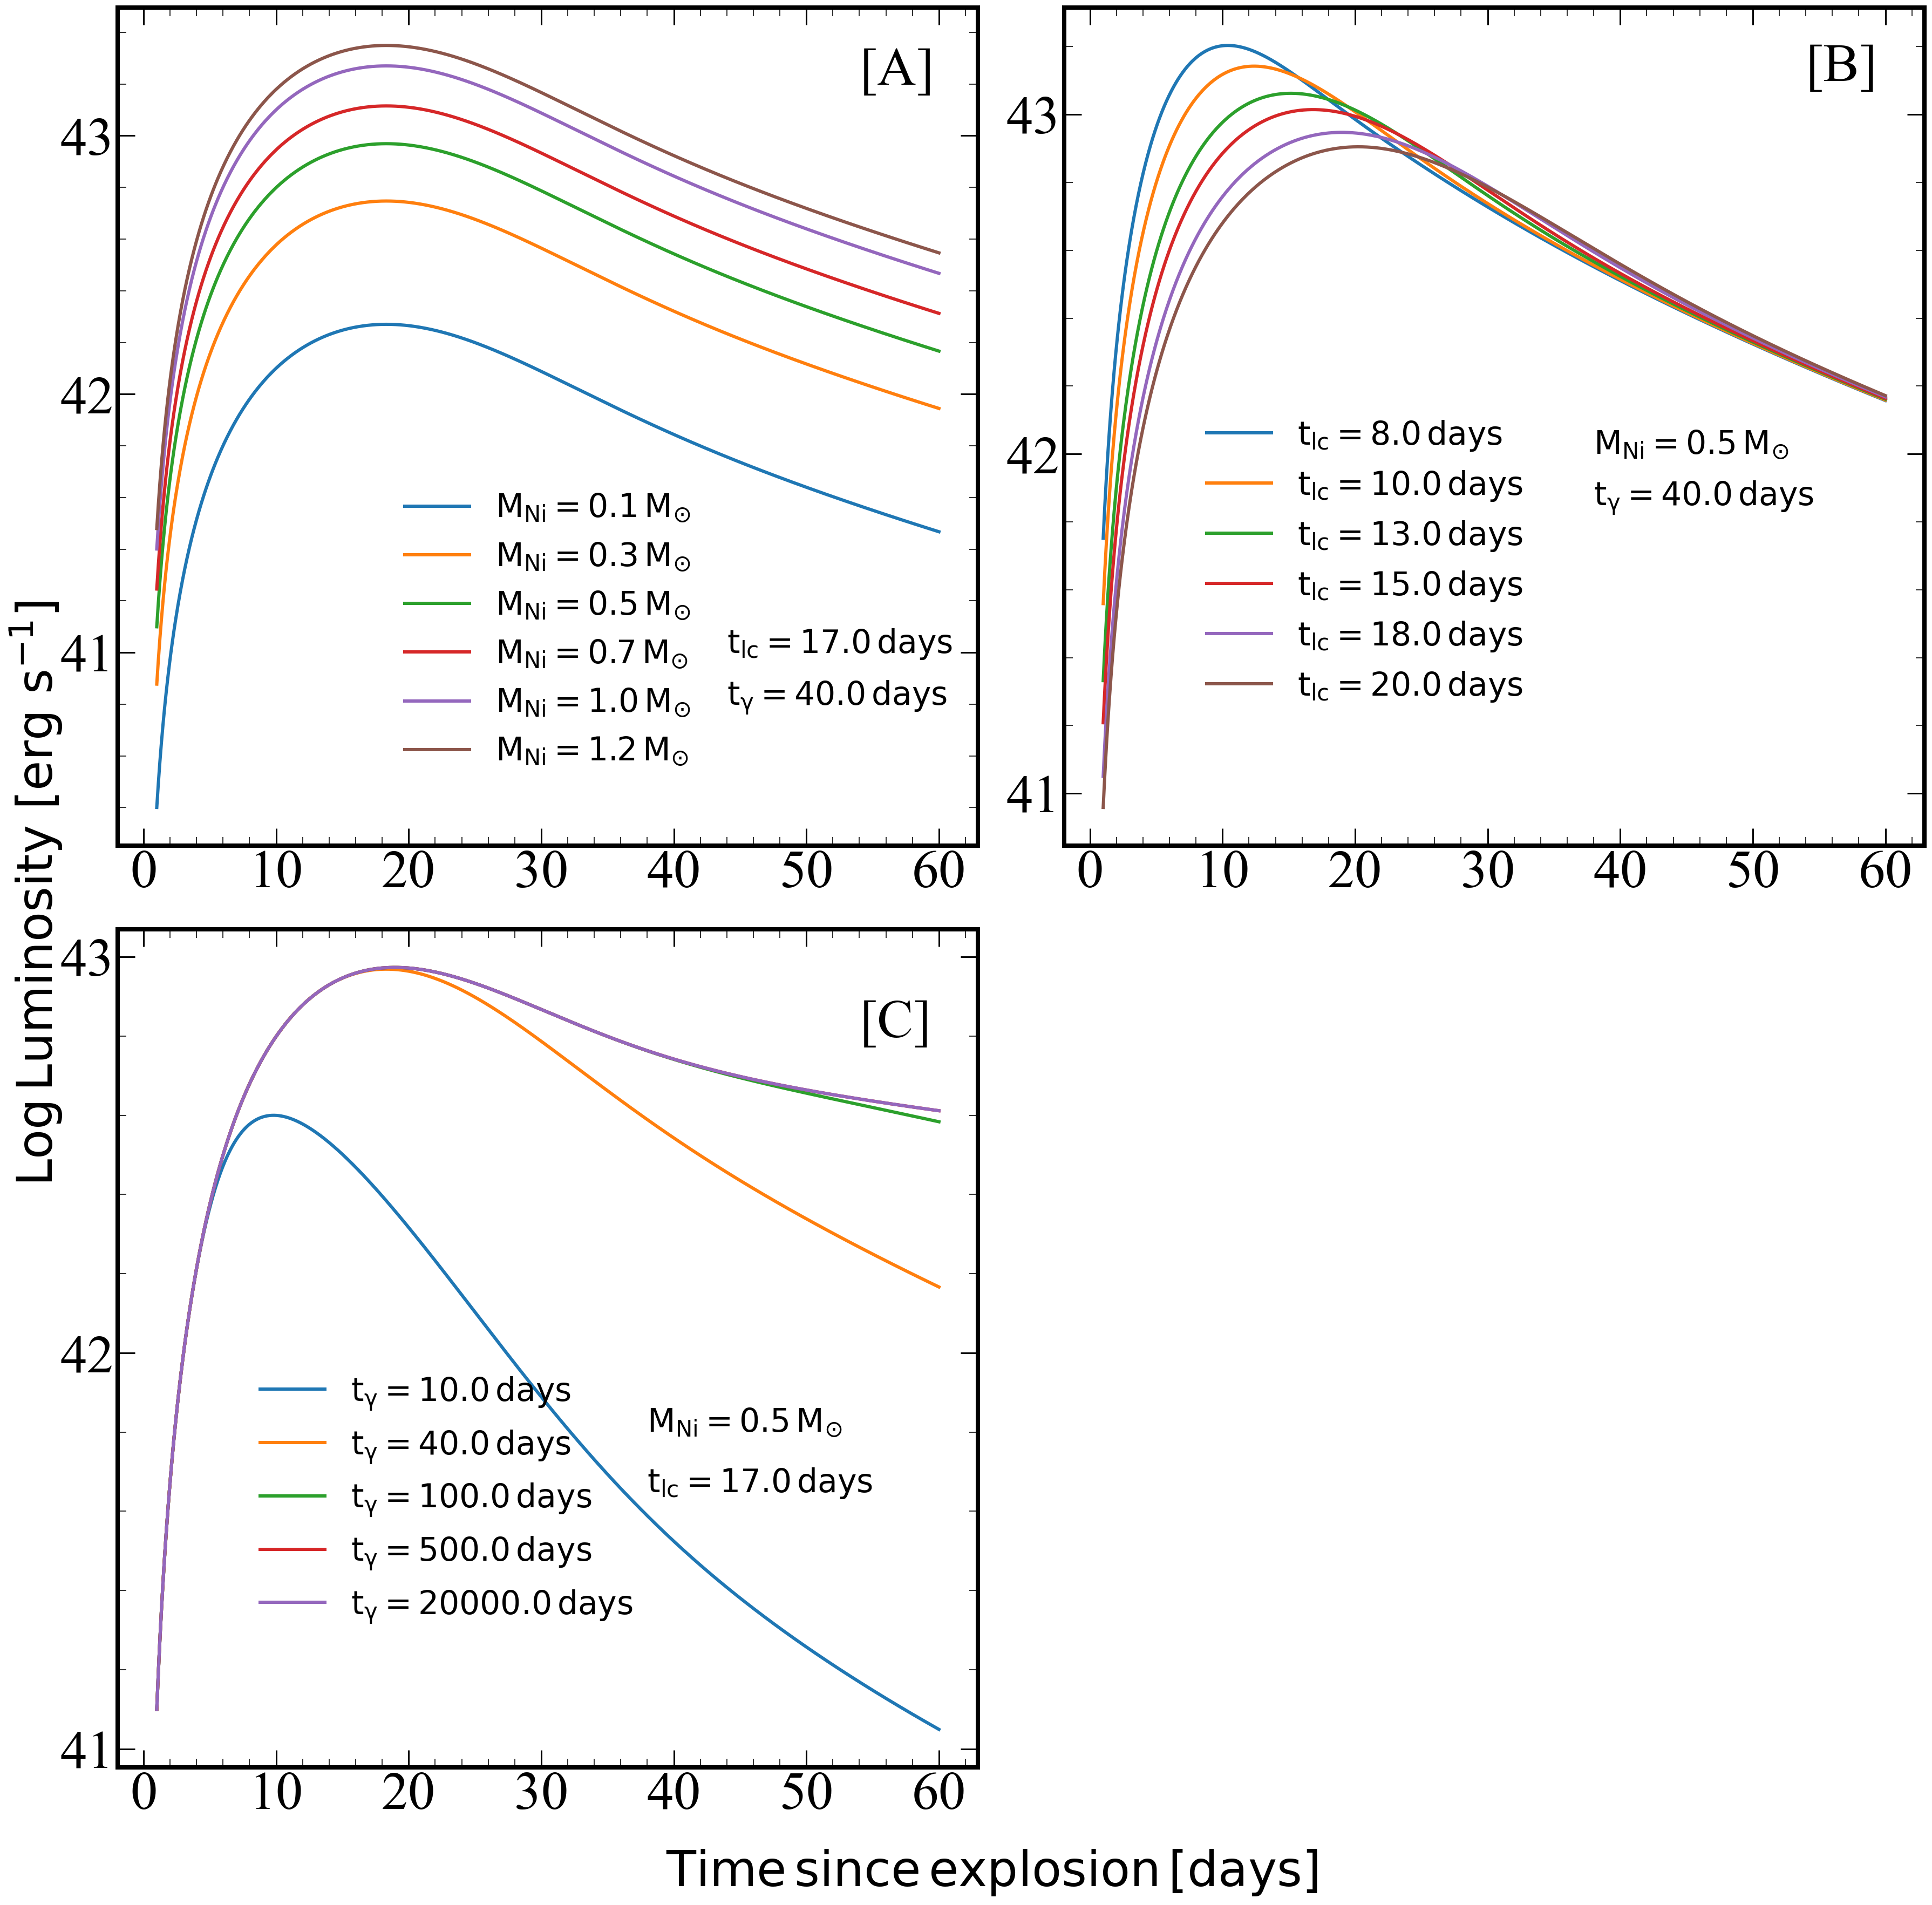

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(30, 30))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.delaxes(axs[1, 1])

#===================================================================================================#
#Effect of ni mass
plot_params(axs[0,0], 10, 2, 1.0, 0.2, s=50)
ni_mass = [0.1, 0.3, 0.5, 0.7, 1.0, 1.2]
t_lc = 17.0      
t_g = 40 

t = np.linspace(1, 60, 1000)

for j in range(len(ni_mass)):
    
    lum = Rad_Diffusion(ni_mass[j], t_lc, t_g, t)
    axs[0,0].plot(t, np.log10(lum), lw=3.0, label=r'$\rm M_{Ni}=%.1f\, M_{\odot}$'%ni_mass[j])
    
axs[0,0].legend(loc="best", fontsize=30, fancybox=False, frameon=False, borderaxespad=2.0)
axs[0,0].text(44, 41, r'$\rm t_{lc}=17.0\, days$', fontsize=30)
axs[0,0].text(44, 40.8, r'$\rm t_{\gamma}=40.0\, days$', fontsize=30)
axs[0,0].text(54, 43.2, r'[A]', fontsize=50)
#===================================================================================================#
#Effect of t_lc

plot_params(axs[0,1], 10, 2, 1.0, 0.2, s=50)
ni_mass_ = 0.5
t_lc = [8.0, 10.0, 13.0, 15.0, 18.0, 20.0] 
t_g = 40 

t = np.linspace(1, 60, 1000)

for j in range(len(t_lc)):
    
    lum = Rad_Diffusion(ni_mass_, t_lc[j], t_g, t)
    axs[0,1].plot(t, np.log10(lum), lw=3.0, label=r'$\rm t_{lc}=%.1f\, days}$'%t_lc[j])
    
axs[0,1].legend(loc="lower left", fontsize=30, fancybox=False, frameon=False, borderaxespad=4.0)
axs[0,1].text(38, 42, r'$\rm M_{Ni}=0.5\, M_{\odot}$', fontsize=30)
axs[0,1].text(38, 41.85, r'$\rm t_{\gamma}=40.0\, days$', fontsize=30)
axs[0,1].text(54, 43.1, r'[B]', fontsize=50)
#===================================================================================================#
# Effect of t_gamma

plot_params(axs[1,0], 10, 2, 1.0, 0.2, s=50)
ni_mass_ = 0.5
t_lc = 17.0 
t_g = [10, 40, 100, 500, 20000] 

t = np.linspace(1, 60, 1000)

for j in range(len(t_g)):
    
    lum = Rad_Diffusion(ni_mass_, t_lc, t_g[j], t)
    axs[1,0].plot(t, np.log10(lum), lw=3.0, label=r'$\rm t_{\gamma}=%.1f\, days}$'%t_g[j])
    
axs[1,0].legend(loc="best", fontsize=30, fancybox=False, frameon=False, borderaxespad=4.0)
axs[1,0].text(38, 41.8, r'$\rm M_{Ni}=0.5\, M_{\odot}$', fontsize=30)
axs[1,0].text(38, 41.65, r'$\rm t_{lc}=17.0\, days$', fontsize=30)
axs[1,0].text(54, 42.8, r'[C]', fontsize=50)

fig.text(.5, 0.08, r'$\rm Time\, since\, explosion\, [days]$', 
         ha='center', va='center', rotation='horizontal', fontsize=45);

fig.text(0.09, .5, r'$\rm Log\, Luminosity\ [erg~s^{-1}]$', 
         ha='center', va='center', rotation='vertical', fontsize=45);

plt.savefig("/Users/anirbandutta/Documents/Thesis_plots/Understanding_Arnett.png", dpi=100, bbox_inches="tight")
